<a href="https://colab.research.google.com/github/brkunver/depresyon-siniflandirma/blob/master/depresyon_siniflandirma.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Burakhan ünver - 18253066
#Hesaplamalı sinirbilim dersi için hazırlanmıştır
#https://colab.research.google.com/drive/1bGhIEOBNRBqf4EZWQlc3PsEGBQ1JU5tx?usp=sharing
#Gerekli importlar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string
from wordcloud import WordCloud
from collections import Counter
import nltk

from nltk import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
!pip install scikit-plot
from scikitplot.metrics import plot_confusion_matrix, plot_roc

nltk.download('stopwords')
nltk.download('punkt')
df = pd.read_excel("dataset.xlsx");
df = df.dropna(how="any");
df.text = df.text.astype(str)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



# Projenin amacı
Elimizdeki verisetini kullanarak öğrencilerin depresif durumda olup olmadığını tahmin eden bir model geliştirmek

# Verisetinin tanıtımı
Bu veriseti yaklaşık 6500 satırlık sosyal medya yorumları ve gönderileri içermektedir.

Verisetindeki gönderiler iyi seviyede ingilizce konuşan lisans öğrencileri arasından seçilmiştir.

## Verisetindeki verilerin anlamı
Verisetinde "text" ve "label" olmak üzere 2 sütun bulunmaktadır. "text" sütunu sosyal medya gönderisini temsil ederken "label" sütunu bu gönderinin ait olduğu kişinin depresif olup olmadığını 1 veya 0 ile temsil etmektedir.

Aşağıdaki verisetinin örnek bir kısmını görebiliriz.

In [ ]:
df

,text,label
0,oh my gosh,1.0
1,"trouble sleeping, confused mind, restless hear...",1.0
2,"All wrong, back off dear, forward doubt. Stay ...",1.0
3,I've shifted my focus to something else but I'...,1.0
4,"I'm restless and restless, it's been a month n...",1.0
...,...,...
6977,I can't forget you #SpiritHadrian,0.0
6978,€ ®šæœŸâ˜†ã€'..DJ DAIKI! DJ DAIKI! DJ DAIKI!.D...,0.0
6979,Dai5y! <3,0.0
6980,tired of clowns but still hopefully tonight if...,0.0


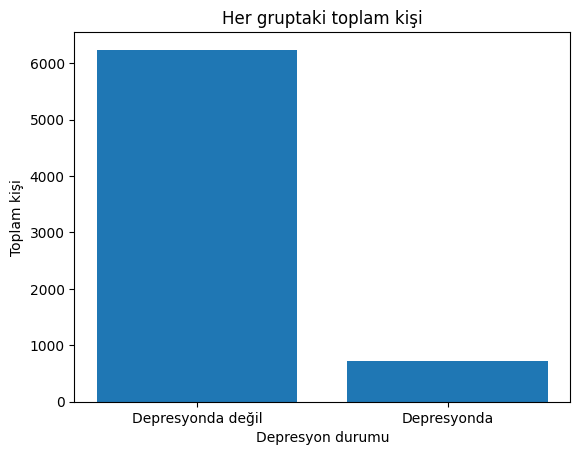

In [ ]:
label_counts = df['label'].value_counts();
 
plt.bar(label_counts.index, label_counts.values);

plt.xlabel('Depresyon durumu');
plt.ylabel('Toplam kişi');
plt.title('Her gruptaki toplam kişi');

plt.xticks(label_counts.index, ['Depresyonda değil', 'Depresyonda']);
plt.show()

### Üstteki grafikte depresyon durumlarına göre verisetindeki kişilerin sayısını görüyoruz

**Depresyon içerenler = 733 veri**

**Depresyon içermeyenler = 6247 veri**

In [ ]:
df["kelime_sayisi"] = df.text.astype(str).apply(lambda x: len(x.split()))

## Verileri daha iyi incelemek için her gönderinin kaç kelime içerdiğini de verisetine ekliyoruz.

In [ ]:
df.head()

,text,label,kelime_sayisi
0,oh my gosh,1.0,3
1,"trouble sleeping, confused mind, restless hear...",1.0,10
2,"All wrong, back off dear, forward doubt. Stay ...",1.0,14
3,I've shifted my focus to something else but I'...,1.0,11
4,"I'm restless and restless, it's been a month n...",1.0,14


In [ ]:
df.groupby("label")["kelime_sayisi"].mean()

label
0.0    12.322276
1.0    15.913699
Name: kelime_sayisi, dtype: float64

## Depresyonda olanlar ortalama **12.3** kelime ile gönderi atarken depresyonda olmayanlar ortalama **15.8** kelime kullanmıştır

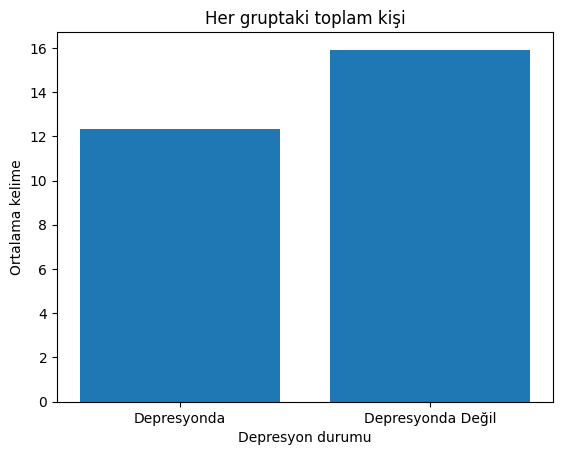

In [ ]:
plt.bar(df.groupby("label")["kelime_sayisi"].mean().index,df.groupby("label")["kelime_sayisi"].mean().values)
plt.xlabel('Depresyon durumu');
plt.ylabel('Ortalama kelime');
plt.title('Her gruptaki toplam kişi');

plt.xticks(label_counts.index, ['Depresyonda', 'Depresyonda Değil']);
plt.show()

# Veri işleme bölümü
Bu aşamadan sonra verilerin tutarlı olabilmesi ve algoritmaların doğru çalışabilmesi için verileri işleyeceğiz

## Verilerin tamamını küçük harfe dönüştürme işlemi

In [ ]:
def convert_lowercase(text):
    text = text.lower()
    return text

df['text'] = df['text'].apply(convert_lowercase)

## Noktalama işaretlerini veriden temizleme

In [ ]:
def remove_punc(text):
    return text.translate(str.maketrans('', '', string.punctuation))

df['text'] = df['text'].apply(remove_punc)

# Stopword temizleme
**Stopword** İngilizce'de çokça kullanılan **"the","can","of","a"** gibi bağlaçlardır. Verisetinden bu bağlaçları temizleme işlemi yapıyoruz.

In [ ]:
def remove_stopwords(text):
    new_list = []
    words = word_tokenize(text)
    stopwrds = stopwords.words('english')
    for word in words:
        if word not in stopwrds:
            new_list.append(word)
    return ' '.join(new_list)

df['text'] = df['text'].apply(remove_stopwords)

# Kelime kökü bulma
**Stemming** işlemi yaparak kelimelerin **kökünü** bulma işlemi yapacağız

**Örnek :**

**"Programmers program with programming languages"** =>

**Program program with program language**

In [ ]:
def perform_stemming(text):
    stemmer = PorterStemmer()
    new_list = []
    words = word_tokenize(text)
    for word in words:
        new_list.append(stemmer.stem(word))

    return " ".join(new_list)

df['text'] = df['text'].apply(perform_stemming)

In [ ]:
#Tüm işlemlerden sonra veri tablosu, kelime_sayisi ilk veriye göre kalmıştır
df.head()

,text,label,kelime_sayisi
0,oh gosh,1.0,3
1,troubl sleep confus mind restless heart tune,1.0,10
2,wrong back dear forward doubt stay restless re...,1.0,14
3,ive shift focu someth els im still worri,1.0,11
4,im restless restless month boy mean,1.0,14


# Depresyonda olmayan kişilerin en çok kullandığı kelimelerin yoğunluk grafiği

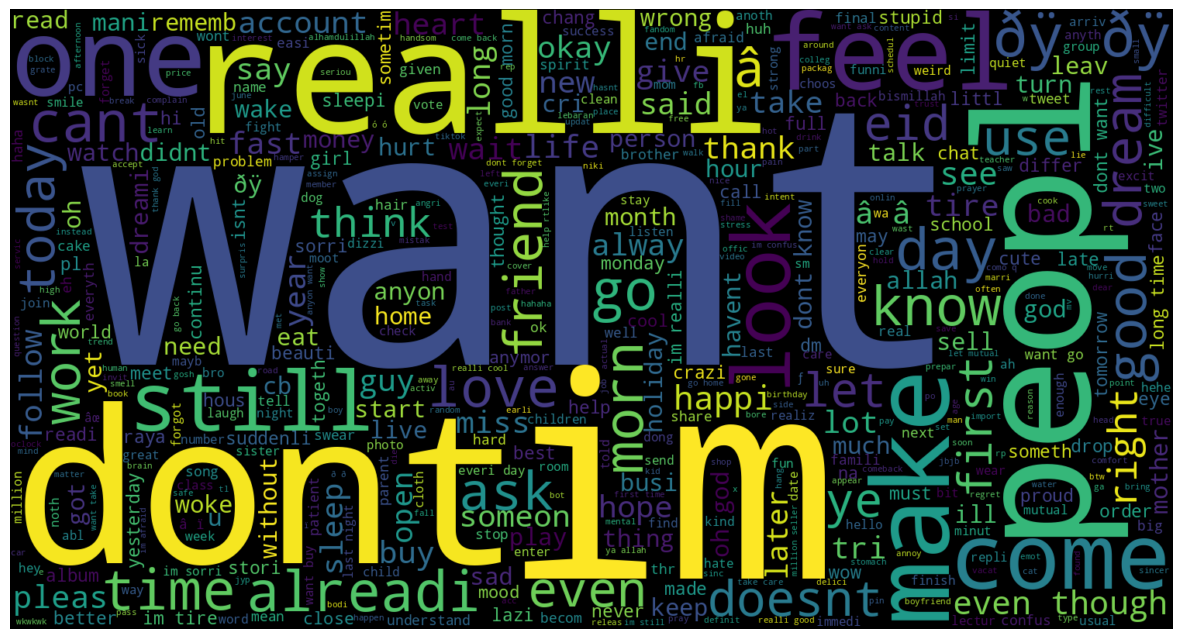

In [ ]:
text = " ".join(df[df['label'] == 0]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Depresyonda olan kişilerin en çok kullandığı kelimelerin yoğunluk grafiği

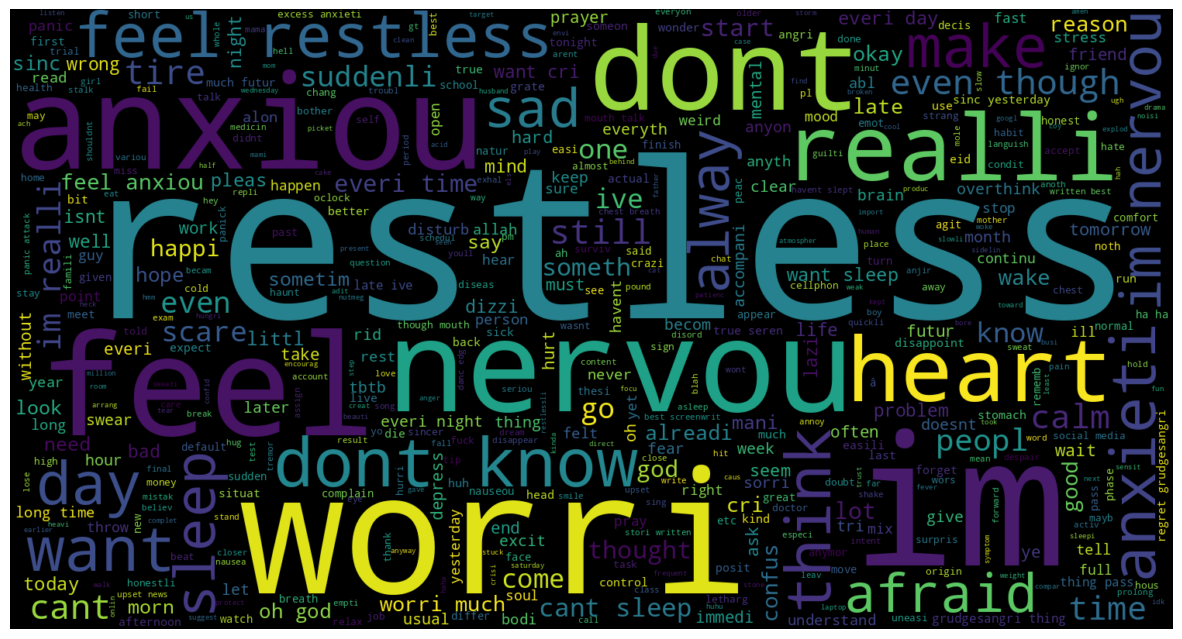

In [ ]:
text = " ".join(df[df['label'] == 1]['text'])
plt.figure(figsize = (15, 10))
wordcloud = WordCloud(max_words=500, height= 800, width = 1500,  background_color="black", colormap= 'viridis').generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# Vektorizasyon ve eğitim test verisi ayırma işlemleri
Verileri son olarak eğitim ve test verisi olarak ayırıyoruz ve vektör haline getiriyoruz.

In [ ]:
X = df["text"]
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 42, stratify = y)

tfidf = TfidfVectorizer(max_features= 2500, min_df= 2)
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

# Model yardımcı fonksiyonu oluşturma
Bu aşamada modelimizi parametre olarak alacak ve eğitim işlemi yapacak, aynı zamanda grafik çizme ve test doğruluk oranı yazdıracak yardımcı fonksiyonumuzu tanımlıyoruz.

In [ ]:
def train_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    accuracy = round(accuracy_score(y_test, y_pred), 3)
    precision = round(precision_score(y_test, y_pred), 3)
    recall = round(recall_score(y_test, y_pred), 3)

    print(f'Accuracy of the model: {accuracy}')
    print(f'Precision Score of the model: {precision}')
    print(f'Recall Score of the model: {recall}')

    sns.set_context('notebook', font_scale= 1.3)
    fig, ax = plt.subplots(1, 2, figsize = (25,  8))
    ax1 = plot_confusion_matrix(y_test, y_pred, ax= ax[0], cmap= 'YlGnBu')
    ax2 = plot_roc(y_test, y_prob, ax= ax[1], plot_macro= False, plot_micro= False, cmap= 'summer')

# Algoritma Seçimi - Random Forest
Bu algoritma, birçok karar ağacının birleşiminden oluşan bir algoritmadır.

Her bir karar ağacı rastgele seçilen örneklerle ve özelliklerle eğitilir. Ardından bu ağaçların birleşimi ile sonuç elde edilir.

## Sonuçlar
Modeli eğittikten sonra altta doğruluk oranlarını ve tahmin grafiklerini görebiliriz.

Accuracy of the model: 0.99
Precision Score of the model: 0.978
Recall Score of the model: 0.925


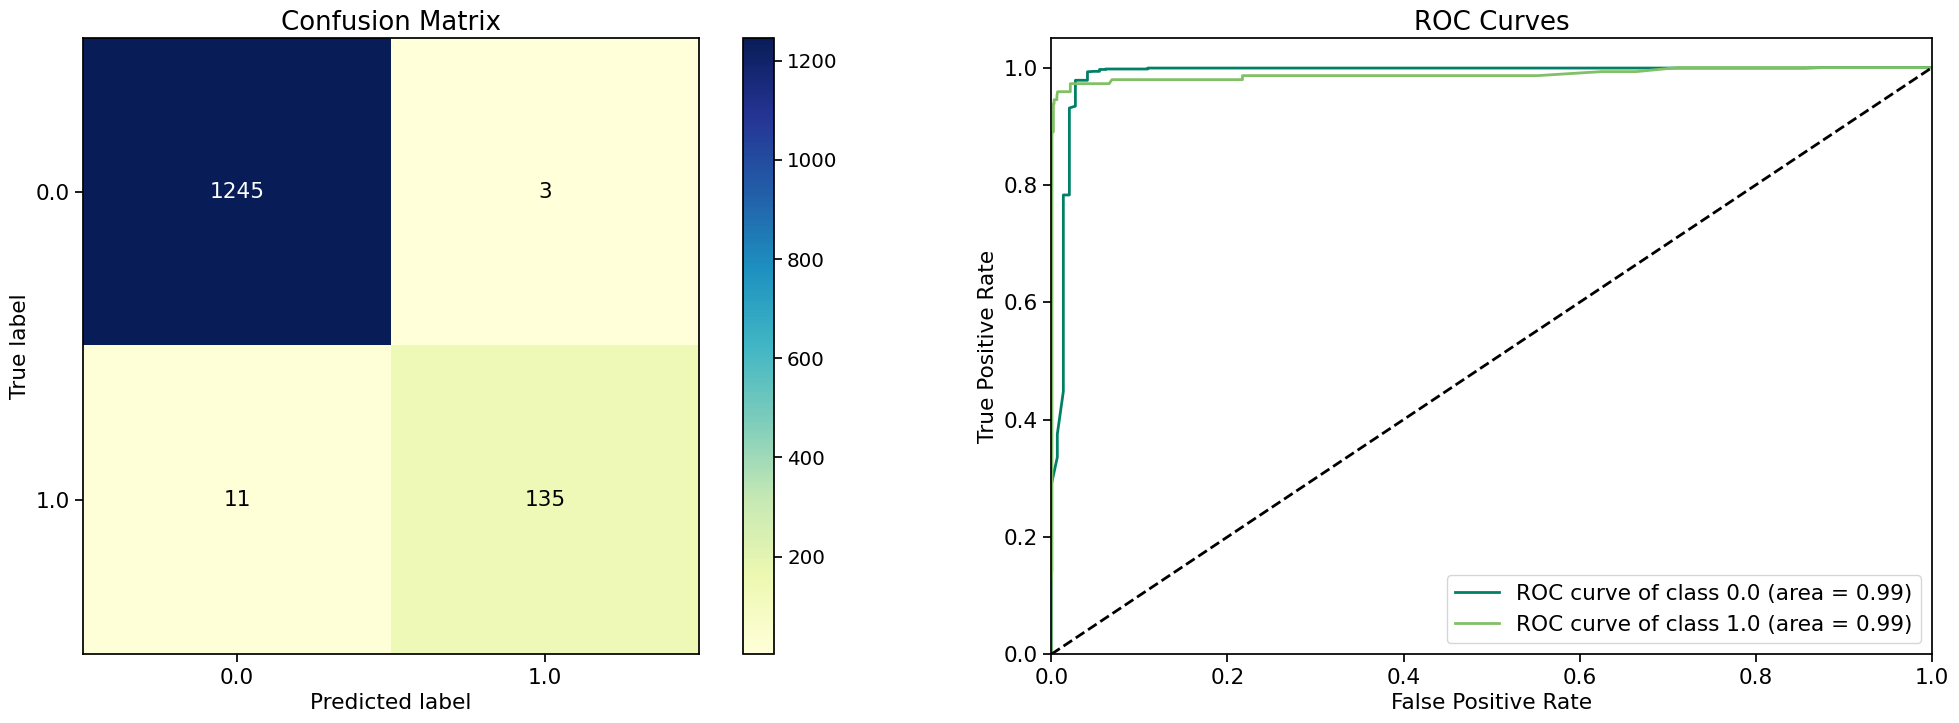

In [ ]:
rf = RandomForestClassifier(n_estimators= 300)
train_model(rf)

# Kaynaklar
https://www.kaggle.com/datasets/sahasourav17/students-anxiety-and-depression-dataset

https://www.kaggle.com/code/sasakitetsuya/students-anxiety-and-depression-classify-model

https://scikit-learn.org/1.0/modules/generated/sklearn.metrics.plot_confusion_matrix.html

https://www.w3schools.com/python/python_ml_confusion_matrix.asp

https://stackoverflow.com/questions/59809713/modulenotfounderror-no-module-named-scikitplot

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

https://www.nltk.org/howto/stem.html

https://www.geeksforgeeks.org/python-stemming-words-with-nltk/

https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

https://www.ibm.com/topics/random-forest

## Hazırlayan
Burakhan ünver 